## Packages Galore

In [1]:
import os
import sys
import re
import warnings
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Astro 480 Labs and PSets\\Lab 4 - Data Reduction & Photometry'

In [40]:
sys.path.append('..\\..\\interacting_galaxies') # for laptop 
sys.path.append('..\\..\\Interacting Galaxies Project') # for desktop
from funcrefs import fnrefs as rfs
from funcrefs import convenience_functions as cf

import numpy as np
import astropy.units as u

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import astropy.visualization as vis
import seaborn as sns

from astropy.io import fits
from astropy.wcs import WCS
import ccdproc as ccdp
from astropy.nddata import CCDData

import photutils as pu
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus

Notes for Observation Shifts
- for ngc 2998 if the picture given looks weird it's probably the spectrum pic
- darks are the same length as images you want to reduce (but you can also add some together)
- create a table that lists file names, filter, exposure time, and kind of file
- manually check for correct settings by downloading and opening fits file (don't trust preview screen)
- keep original data as raw
- [ccd data reduction guide](https://ccdproc.readthedocs.io/en/latest/)
- no overscans on ARCSAT

## <b>Data Reduction</b>

[CCD Data Reduction Guide](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html)

In [17]:
# creating a custom colormap
N = 256
colors = ["black", "xkcd:very dark purple", 
          "xkcd:cornflower", "xkcd:light blue grey", "xkcd:light khaki",
          "xkcd:dandelion"]
custom = LinearSegmentedColormap.from_list("custom", colors, N=N)

#### <u>Plotting Uncalibrated Stacks</u>

In [18]:
ngc_gstack = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_g.fits')[0].data

ngc_hastack = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_ha.fits')[0].data

ngc_istack = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_i.fits')[0].data

ngc_rstack = fits.open('../../Interacting Galaxies Project/NGC 4567/combo_r.fits')[0].data

filters = ['g', 'ha', 'i', 'r']
ngc_rawst = [ngc_gstack, ngc_hastack, ngc_istack, ngc_rstack]

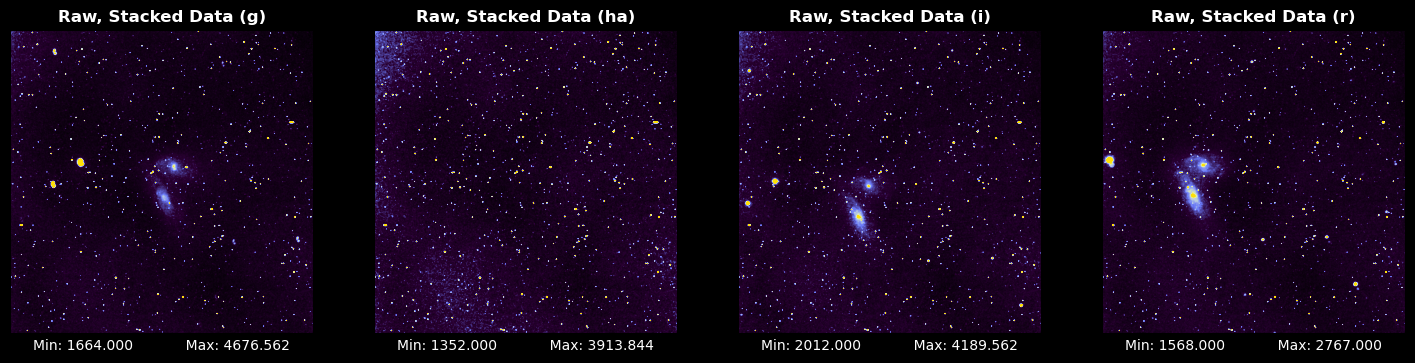

In [19]:
# for a 4x1 grid, swap the rows and columns and figsize
fig, axs = plt.subplots(1, 4, figsize=(18, 9))
fig.set_facecolor('black')
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

for i, (filter, data) in enumerate(zip(filters, ngc_rawst)):
    # Raw data
    vis_vmin, vis_vmax = np.percentile(data, [1, 99.75])
    norm = vis.ImageNormalize(data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())

    axs[i].imshow(data, cmap=custom, norm=norm, interpolation='gaussian')
    axs[i].set_title(f'Raw, Stacked Data ({filter})', weight='bold', color='white')
    axs[i].set_xlabel(f'Min: {vis_vmin:.3f}            Max: {vis_vmax:.3f}', color='white')

#### <u>Bias & Overscan</u>

1. <b>Define the bias. Include both a description of what it looks like physically, why it occurs, and how we take it into account (how do we remove its effect on our data images?)</b>

    A bias is a 0-second blank photo that records noise coming from the lens.

2. <b>Why would we use more than one bias frame?</b>

    The more bias frames you have the better you can remove noisy data from the pure photometric data. 
    This is helpful for being more precise with your values.

3. <b>List the average value of each of your bias frames, as well as your final master bias.</b>

    See below.

4. <b>Define "overscan".</b>

    

5. <s><b>Skip 5 (ARCSAT has no overscan)</b></s>

In [6]:
bias_files = []
print("Average Bias Values (for each file)")
for file in os.listdir('../../Interacting Galaxies Project/biases'):
    if re.search("Bias_", file):
        with fits.open('../../Interacting Galaxies Project/biases/' + file) as hdul:
            data = hdul[0].data
            print(f"{np.mean(data):.3f}")
            bias_files.append(np.mean(data))
print(f"Standard Deviation: {np.std(bias_files):.3f}")

bias = fits.open('../../Interacting Galaxies Project/biases/master_bias.fits')[0].data
print(f"\nMaster Bias avg: {np.mean(bias):.3f}")

Average Bias Values (for each file)
1292.332
1292.311
1292.364
1292.303
1292.327
1292.282
1292.422
1292.429
1292.397
1292.422
1292.411
1292.365
Standard Deviation: 0.050

Master Bias avg: 1292.391


([], [])

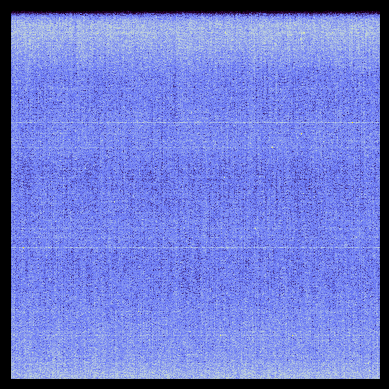

In [20]:
plt.figure(facecolor='black')
b_vmin, b_vmax = np.percentile(bias, [1, 99.75])
dark_norm = vis.ImageNormalize(bias, vmin=b_vmin, vmax=b_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
plt.imshow(bias, cmap=custom, norm=dark_norm, interpolation='hermite')
plt.xticks([])
plt.yticks([])

#### <u>Flat Fields</u>

6. <b>Which filters do you have flat fields for? List the flat field file names for each filter that you need. Do you have more flats than you need? Confirm that your flat fields have the same binning as your data.</b>

    Filters: g, H-$\alpha$, i, r. 
    
    I'm not sure if there's a minimum amount of flats to have but in my opinion it doesn't hurt to have more! There are 5 flats for each filter. 
    
    See below for file names and confirming binning.

7. <b>Why do we need flat fields for each filter we have used for observations?</b>

    Similar to biases, these help to remove noise in the raw photometric data but are helpful for specifically pinpointing noise more prevalent in the correlating filter. Biases are more general and pertain to the noise coming from the telescope itself, where flats are for noise coming from the atmosphere or other parts of the sky.

In [8]:
# normalizing the flats before stacking
norm_flat = { # only flats need to be normalized 
    'g': rfs.create_stack('../../Interacting Galaxies Project/flats/g flats/', keyword='domeflat', normalize=True),
    'ha': rfs.create_stack('../../Interacting Galaxies Project/flats/ha flats/', keyword='domeflat', normalize=True),
    'i': rfs.create_stack('../../Interacting Galaxies Project/flats/i flats/', keyword='domeflat', normalize=True),
    'r': rfs.create_stack('../../Interacting Galaxies Project/flats/r flats/', keyword='domeflat', normalize=True)
}
'''my function uses median combine instead of sigma clipping'''

'my function uses median combine instead of sigma clipping'

In [9]:
# printing out raw file names and normalized master values
for filter in ["g flats", "ha flats", "i flats", "r flats"]:
    relpath = "../../Interacting Galaxies Project/flats/"
    nm = [file for file in os.listdir(os.path.relpath(relpath + filter)) if file.startswith('domeflat')]

    # printing out normalized average value
    print(f"\n[{filter}] ({len(nm)} files)".ljust(35) + (f"[Master Average] {np.mean(norm_flat[filter.split()[0]]):>11.3f}"))

    filter_frames = []
    for file in nm:
        with fits.open(relpath + "/" + filter + "/" + file) as hdul:
            data = hdul[0].data
            filter_frames.append(np.mean(data))
            print(f"{file:<35} Average Value: {np.mean(data):>11.3f}")

    # the raw standard deviation is really high --> i.e. why flats are normalized before stacking
    print(f"{'Standard Deviation:':>50} {np.std(filter_frames):>11.3f}")


[g flats] (5 files)               [Master Average]    7746.297
domeflat_g_001-2_050224.fits        Average Value:   18175.704
domeflat_g_001_050224.fits          Average Value:   18162.824
domeflat_g_001_050524.fits          Average Value:   18175.602
domeflat_g_002_050524.fits          Average Value:   19789.304
domeflat_g_003_050524.fits          Average Value:   19939.818
                               Standard Deviation:     830.865

[ha flats] (5 files)              [Master Average]    7676.117
domeflat_Ha_001-2_050224.fits       Average Value:   18246.795
domeflat_Ha_001_050224.fits         Average Value:   18232.767
domeflat_Ha_001_050524.fits         Average Value:   18264.449
domeflat_Ha_002_050524.fits         Average Value:   19799.890
domeflat_Ha_003_050524.fits         Average Value:   19992.406
                               Standard Deviation:     809.777

[i flats] (5 files)               [Master Average]    8138.241
domeflat_i_001-2_050224.fits        Average Value:  

#### <u>Darks</u>

If your science images here are short, the dark current is extremely low and so we ignore it here. If you are taking longer images, or on instruments with lots of dark current, you can’t neglect this term of the noise in reduction. Make sure to take into account darks

In [10]:
dark_files = []
print("Average Dark Values (for each file)")
for file in os.listdir('../../Interacting Galaxies Project/darks'):
    if re.search("Dark_", file):
        with fits.open('../../Interacting Galaxies Project/darks/' + file) as hdul:
            data = hdul[0].data
            print(f"{np.mean(data):.3f}")
            dark_files.append(np.mean(data))
print(f"Standard Deviation: {np.std(dark_files):.3f}")

dark = fits.open('../../Interacting Galaxies Project/darks/master_dark.fits')[0].data
print(f"\nMaster Dark avg: {np.mean(bias):.3f}")

Average Dark Values (for each file)
1344.315
1344.136
1344.089
Standard Deviation: 0.097

Master Dark avg: 1292.391


([], [])

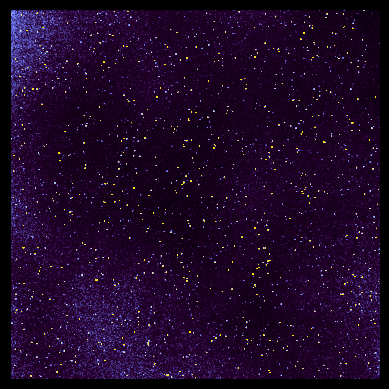

In [21]:
plt.figure(facecolor='black')
d_vmin, d_vmax = np.percentile(dark, [1, 99.75])
dark_norm = vis.ImageNormalize(dark, vmin=d_vmin, vmax=d_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
plt.imshow(dark, cmap=custom, norm=dark_norm, interpolation='hermite')
plt.xticks([])
plt.yticks([])

#### <u>Saving/Visualizing Subtractions</u>

In [16]:
# commenting out, only needs to be run once
# for i, (filter, data) in enumerate(zip(filters, ngc_rawst)):
    
#     calibrated_data = ((data - bias - dark) / norm_flat[filter])
#     fits.writeto(f'../../Interacting Galaxies Project/NGC 4567/calibrated_{filter}.fits', calibrated_data, overwrite=True)

In [13]:
ngc_g_calbr = fits.open('../../Interacting Galaxies Project/NGC 4567/calibrated_g.fits')[0].data

ngc_ha_calbr = fits.open('../../Interacting Galaxies Project/NGC 4567/calibrated_ha.fits')[0].data

ngc_i_calbr = fits.open('../../Interacting Galaxies Project/NGC 4567/calibrated_i.fits')[0].data

ngc_r_calbr = fits.open('../../Interacting Galaxies Project/NGC 4567/calibrated_r.fits')[0].data

ngc_calbr = [ngc_g_calbr, ngc_ha_calbr, ngc_i_calbr, ngc_r_calbr]

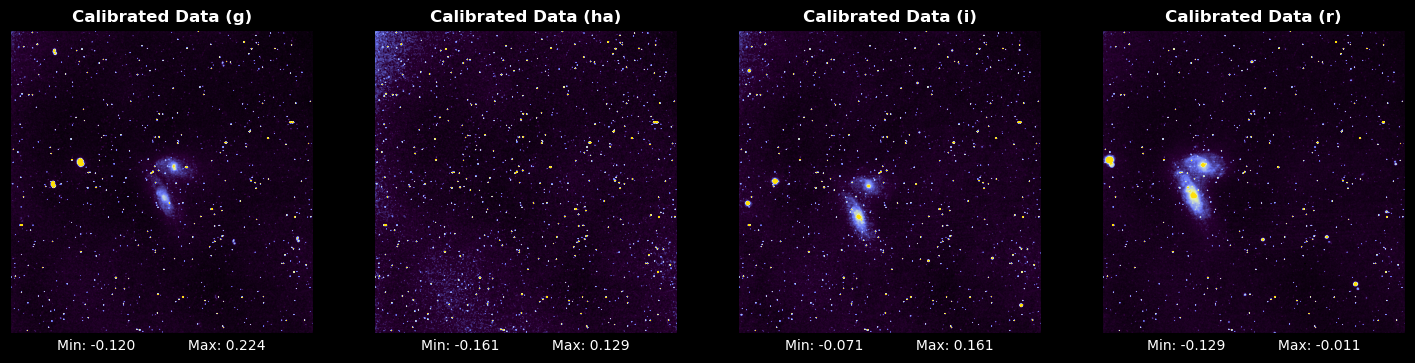

In [79]:
# for a 4x1 grid, swap the rows and columns and figsize
fig, axs = plt.subplots(1, 4, figsize=(18, 9))
fig.set_facecolor('black')
for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

for i, (filter, data) in enumerate(zip(filters, ngc_calbr)):
    
    vis_vmin, vis_vmax = np.percentile(data, [1, 99.75])
    norm = vis.ImageNormalize(data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())

    axs[i].imshow(data, cmap=custom, norm=norm, interpolation='gaussian')
    axs[i].set_title(f'Calibrated Data ({filter})', weight='bold', color='white')
    axs[i].set_xlabel(f'Min: {vis_vmin:.3f}            Max: {vis_vmax:.3f}', color='white')

## <b>Data Analysis (Photometry)</b>

You now have images that are as close as we can get to what was emitted from our source. You can either use one of the broadband images from your project data or download the image from Canvas to use for this portion of the lab. It will provide an example for the different approaches to photometry you can then use for your project. (The next portion looks for point sources - if you use an image that has a diffuse image, like the nebulas, it might do some weird things for some of the options like DAOStarFinder. If you’re having trouble navigating that - just grab the image on canvas.)

We are going to use the [“photutils”](https://photutils.readthedocs.io/en/stable/) python package to measure the signal.


#### <u>The Sky</u>

We are going to be subtracting the sky on the fly as we use aperture photometry to calculate the flux of the stars in our field. If your primary science object is diffuse or extended, just choose stars in your field that aren’t as overexposed/saturated as your object.

8. What drawbacks could exist from this method of sky subtraction?

    There could be challenges with this method because it can be hard to distinguish pure data from noisy data.

9. Why does sky subtraction matter?

    This can help create a clearer picture and normalize values to account for light from the sky so that the numbers in a histogram are potentially less skewed

#### <u>Source Identification</u>

Identify the sources to perform photometry on in your image. DAOStarFinder is one 
method provided within photutils. Plot the stars found on top of your image. Adjust your parameters to select a smaller set of stars (Between 10-100ish. Depending on your image). Replot. Remove any “bad” stars from the sources array by hand (hot spots, stars on the edge, stars on the overscan)

- for this question, I'm going to use the object image in the r band
- I will be following [this documentation](https://photutils.readthedocs.io/en/stable/detection.html) from photutils

10.  How many objects did you identify with DAOStarFinder? Look at your image. Do you think that’s a reasonable number? What did you change to adjust the number of stars detected? How many stars did you end up with?

In [31]:
# selecting a portion of the region to get a set of stars
x_start, x_end = 0, 400
y_start, y_end = 0, 400
snip = ngc_r_calbr[y_start:y_end, x_start:x_end]
print(f"Shape: {snip.shape} pixels")

snip_mean, snip_median, snip_std = sigma_clipped_stats(snip, sigma=3.0)
print(f"Mean: {snip_mean:.3f}", f"\nMedian: {snip_median:.3f}", f"\nStd: {snip_std:.3f}\n")

Shape: (400, 400) pixels
Mean: -0.117 
Median: -0.119 
Std: 0.007



In [80]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*snip_std)
sources = daofind(snip - snip_median)

for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76, max_lines=7)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
annuli = CircularAnnulus(positions, r_in=4, r_out=6)

 id xcentroid ycentroid sharpness roundness1 ... npix sky  peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ---- ---- ----- -----
  1    200.78      0.95      0.95       0.36 ...   25 0.00 0.07  1.51 -0.45
  2    188.29      3.10      0.95       0.21 ...   25 0.00 0.06  1.22 -0.22
...       ...       ...       ...        ... ...  ...  ...  ...   ...   ...
 66    315.54    358.00      0.93      -0.18 ...   25 0.00 0.75 15.82 -3.00
 67      1.17    359.64      0.65       0.28 ...   25 0.00 0.05  1.35 -0.33
Length = 67 rows


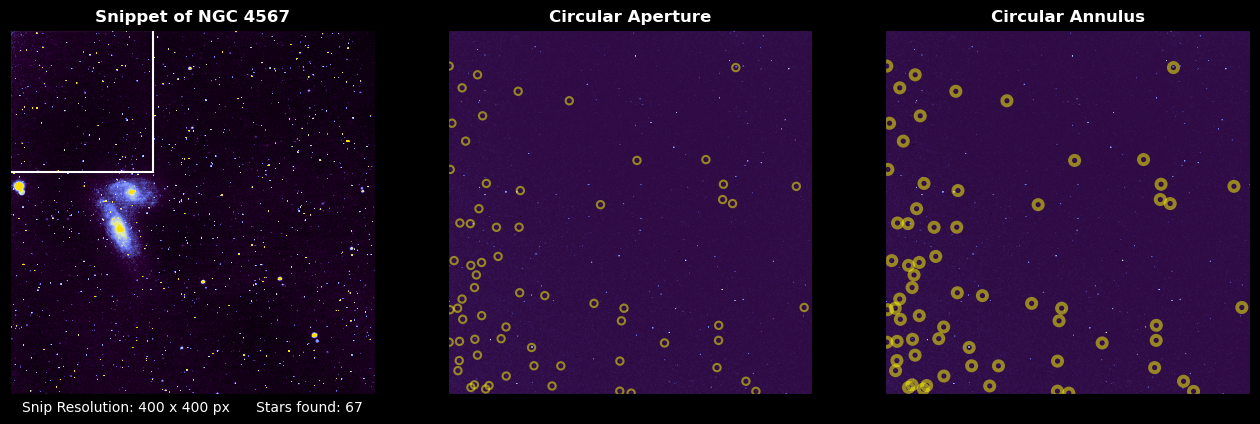

In [106]:
# viewing selection & apertures
with warnings.catch_warnings(): # booo warnings
    warnings.simplefilter('ignore')

    fig = plt.figure(figsize=(16, 9), facecolor='black')

    # plotting r-band image and marking the snippet -----------------------------------------
    plt.subplot(1, 3, 1)
    plt.title(f'Snippet of NGC 4567', weight='bold', color='white')
    plt.xlabel(f'Snip Resolution: {snip.shape[0]} x {snip.shape[1]} px      Stars found: {len(sources)}', color='white')
    
    vmin, vmax = np.percentile(ngc_r_calbr, [1, 99.75])
    vnorm = vis.ImageNormalize(ngc_r_calbr, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    plt.imshow(ngc_r_calbr, cmap=custom, norm=vnorm, interpolation='hermite')
    
    snip_width, snip_height = x_end - x_start, y_end - y_start
    extent = [x_start, x_start + snip_width, y_start, y_start + snip_height]
    norm = vis.ImageNormalize(stretch=vis.SqrtStretch())
    rect = Rectangle((x_start, y_start), snip_width, snip_height, edgecolor='white', facecolor='none', lw=1.5)
    plt.gca().add_patch(rect)


    # plotting apertures --------------------------------------------------------------
    norm = vis.ImageNormalize(stretch=vis.SqrtStretch())

    plt.subplot(1, 3, 2)
    plt.imshow(snip, cmap=custom, origin='lower', norm=norm, interpolation='hermite')
    apertures.plot(color='yellow', lw=1.5, alpha=0.5)
    plt.title(f'Circular Aperture', weight='bold', color='white')
    
    plt.subplot(1, 3, 3)
    plt.imshow(snip, cmap=custom, origin='lower', norm=norm, interpolation='hermite')
    annuli.plot(color='yellow', lw=1.5, alpha=0.5)
    plt.title(f'Circular Annulus', weight='bold', color='white')

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

#### <u>Aperture Photometry</u>

Photutils provides many different kinds of apertures. We will use two here, but other cases (such as galaxies) might require apertures that aren’t round. First, use the “circular aperture” Choose your method and execute your aperture photometry. Review the output. Then plot your apertures on top of your image.  

11. Are you happy with your apertures? Why or why not? Save the list of sources for comparison.

Now we’re going to do the same thing, but instead of using just a circular aperture, we’re going to use annuli. This means you can specify a region for the star, and a nearby region for the sky. This allows us to use the sky that is close to the individual objects to subtract.

Pick your object aperture and note it in your Q12 answers. 
Pick your sky annulus minimum and maximum note it in your Q12 answers.

Now, run as above, except using the “CircularAnnulus” command. Use these two measurements of flux to remove the background from the originally measured flux, and print those results.

12. Make a plot comparing the measurements of the two different methods

ValueError: operands could not be broadcast together with shapes (1024,1024) (67,) 

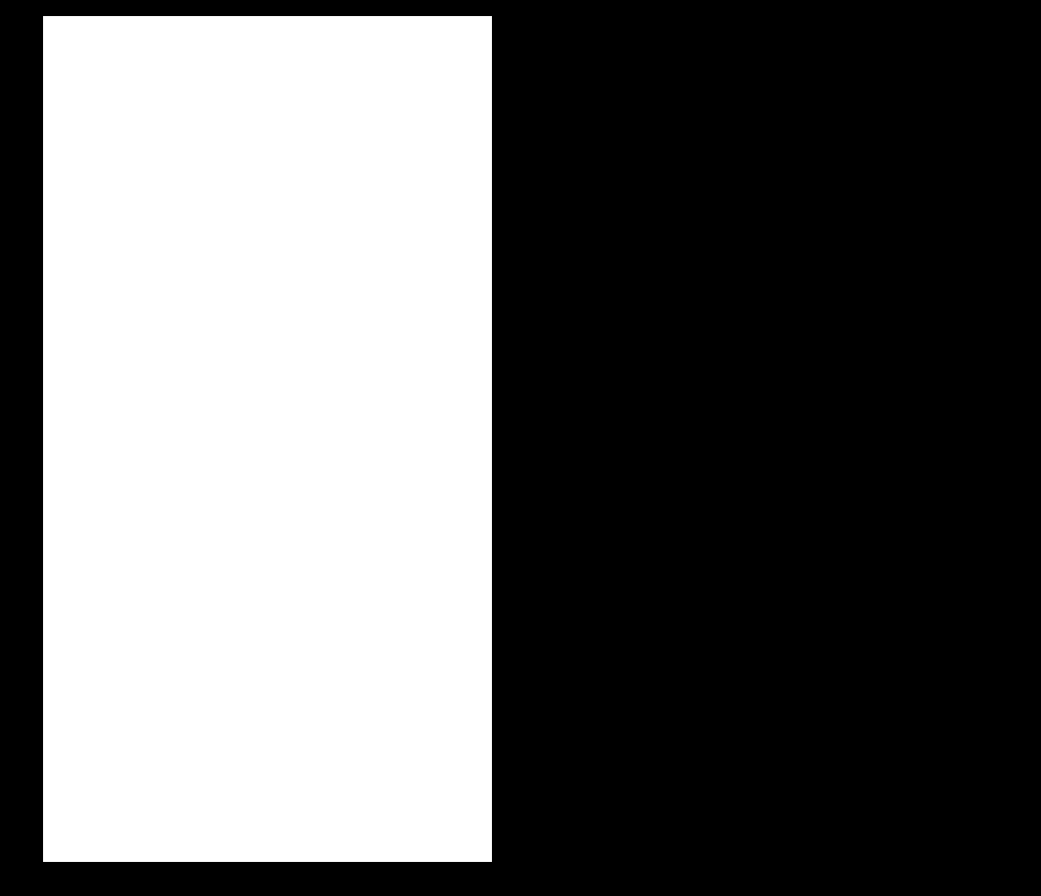

In [71]:
# subtracting the background
with warnings.catch_warnings(): # booo warnings
    warnings.simplefilter('ignore')

    plt.figure(figsize=(11, 11), facecolor='black')
    
    plt.subplot(1, 2, 1)
    subtraction = ngc_r_calbr - apertures
    vmin, vmax = np.percentile(subtraction, [1, 99.75])
    vnorm = vis.ImageNormalize(subtraction, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    plt.imshow(subtraction, cmap=custom, norm=vnorm, interpolation='hermite')
    plt.title(f'Circular Aperture', weight='bold', color='white')
    plt.xlabel(f'Snip Resolution: {snip.shape[0]} x {snip.shape[1]} px      Stars found: {len(sources)}', color='white')

    plt.subplot(1, 2, 2)
    subtraction = ngc_r_calbr - annuli
    vmin, vmax = np.percentile(subtraction, [1, 99.75])
    vnorm = vis.ImageNormalize(subtraction, vmin=vmin, vmax=vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())
    plt.imshow(subtraction, cmap=custom, norm=vnorm, interpolation='hermite')
    plt.title(f'Circular Annulus', weight='bold', color='white')
    plt.xlabel(f'Snip Resolution: {snip.shape[0]} x {snip.shape[1]} px      Stars found: {len(sources)}', color='white')

    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

#### <u>Calculating Flux</u>

Use PSF fitting to calculate the flux of the same set of sources you found with 
DAOstarfinder. Make sure to sky subtract

13. Make a plot comparing the PSF fitting output to the aperture output. Are they the same? Why or why not? 

14. What do you need to do differently for your science image? (For example - are you studying one point source, many point sources, or a diffuse object? What does that change?) 

15. Did you prefer PSF fitting or aperture photometry? Think of one situation that you think would be best for each method.